<a href="https://colab.research.google.com/github/daniela-estevez/ProyectoIntegrador/blob/main/Avance7_Equipo13_Script_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 7. Script Final

## Equipo 13

## Alejandro García Hernández A01793812
## Daniela Estevez Rodriguez A01793723
## Carlos Alberto López Álvarez A01168193

## Objetivos

En este avance, se busca fundamentar si es viable implementar el modelo, evaluando su adecuación a los criterios de éxito previamente establecidos y considerando los resultados obtenidos durante la etapa de modelado.

## 0. Librerías

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
# Librerías a utilizar para el pre procesamiento.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


In [3]:
# Librerías para la sección de modelos supervisados y ensambles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, classification_report, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import BaggingClassifier

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

from IPython.display import display_html

In [5]:
# El siguiente bloque se agregó para poder leer los archivos drive
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks/Proyecto Integrador

In [6]:
# Función para mostrar los DataFrames uno junto al otro con estilos
def display_side_by_side(dfs, captions, color='lightgreen', axis=0):
    html_str = ''
    for caption, df in zip(captions, dfs):
        html_str += '<div style="display: inline-block; padding: 10px;">'
        html_str += f'<h3>{caption}</h3>'
        html_str += df.style.highlight_max(color=color, axis=axis).to_html()
        html_str += '</div>'
    display_html(html_str, raw=True)

## 1. Preparación de datos

Se aplica el pre procesamiento de los datos que se ha trabajado en semanas anteriores. Así, obtenemos dos conjuntos de datos para poder trabajar los datos con diferentes modelos. En el primer conjunto las variables ordinales son codificadas con LabelEncoder y en el segundo conjunto se les aplica OHE.

In [7]:
data = pd.read_csv("base.csv",sep=",", encoding="latin1")
df= data.copy()

In [8]:
# Eliminamos entonces estas características
df = df.drop(["Nombre","residencia","fecha_nacimiento","fecha_1er_visita","FECHA_INICIO_ACTUAL_EPISODIO"], axis=1)
df = df.dropna(axis=1, how='all')

In [9]:
# Calculamos el porcentaje de valores nulos en cada columna
null_percentage = (df.isnull().sum() / len(df)) * 100

# Con el sguiente código, se crea un DataFrame con los porcentajes de valores nulos
null_df = pd.DataFrame({'Columna': null_percentage.index, 'Porcentaje_Null': null_percentage.values})

# Filtramos el DataFrame para mantener solo las columnas donde el porcentaje de valores nulos sea menor al 40%
columnas_a_mantener = null_df[null_df['Porcentaje_Null'] < 40]['Columna']

# Filtramos el DataFrame original para mantener solo las columnas que queremos conservar
df = df[columnas_a_mantener]

In [10]:
#Primero obtenemos las variables que reportan un solo valor y mostramos sus nombres
unique_counts = df.nunique()
columnas_a_eliminar = unique_counts[unique_counts == 1].index
columnas_a_eliminar
df = df.drop(columns=columnas_a_eliminar)

In [11]:
binary_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 2 and all(value in [0, 1] for value in unique_values):
        binary_columns.append(column)

# Número de columnas con solamente 0's o 1's
print("Numero de columnas binarias encontradas:", len(binary_columns))

Numero de columnas binarias encontradas: 28


In [12]:
# Actualizamos el tipo de las columnas binarias a booleano usando astype()
for column in binary_columns:
    df[column] = df[column].astype(bool)

In [13]:
# Lista de variables que son en realidad categóricas
cat_cols=["SEXO","CONDICION_ACTUAL","ESTADO_civil","RELIGION","PROVEEDOR_FAMILIAR","OCUPACIoN_JEFE_FAMILIA","ESCOLARIDAD__JEFE_FAMILIA",
         "ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","CODIGO_DX.1","TRASTORNO_MAYOR_DIAGNOSTICO",
         "Riesgo_suicidio","Sintomas_ansiosos"]

# Actualizamos el tipo de las columnas categoricas usando astype()
for column in cat_cols:
    df[column] = df[column].astype("category")

In [14]:
# Actualizamos el tipo de la columna MENARCA a uno numérico usando astype()
df["MENARCA"] = df["MENARCA"].astype("float64")

In [15]:
# Sustituir los valores de MENARCA donde SEXO es "M"
df.loc[df['SEXO'] == 'M', 'MENARCA'] = -1

# Imputar la moda a las variables numéricas
for columna in df.select_dtypes(include='number').columns:
    df[columna] = df[columna].fillna(df[columna].median())

# Imputar la moda a las variables booleanas
for columna in df.select_dtypes(include='bool').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

# Imputar la moda a las variables alfanuméricas
for columna in df.select_dtypes(include='category').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

In [16]:
# Lista de variables que son en realidad enteros
enteros_cols=["EDAD_1era_visita","EDAD_INICIO_1er_EPISODIO","AnioS_ESTUDIO_PACIENTE","MENARCA","INICIO_VIDA_SEXUAL_ACTIVA","MADRS_TOTAL","CGI-S.1"]

# Actualizamos el tipo de las columnas de enteros usando astype()
for column in enteros_cols:
    df[column] = df[column].astype("int64")

In [17]:
# Eliminamos estas características
df = df.drop(["EPISODIO_MAYOR_total_vida","SUICIDALIDAD_ACTUAL","SUICIDALIDAD_INTENTO_total_vida",
              "B1b_INTENCION_DE_MORIR_EN_ACCIDENTE","B5_PENSO_METODO_SUICIDARSE","B8_PENSO_FECHA_SUICIDIO",
              "B10_INTENCION_SUICIDIO","B18_INTENTO_SUICIDARSE","B2_NECESIDAD_DE_ESTAR_MUERTO","TRASTORNO_MAYOR_PASADO"],
             axis=1)

In [18]:
# Eliminamos estas características
df = df.drop(["CODIGO_DX.1","Puntaje_experto"],
             axis=1)

In [19]:
# Reemplazar el valor 1955 por la mediana
df['EDAD_INICIO_1er_EPISODIO'] = df['EDAD_INICIO_1er_EPISODIO'].replace(1955, df['EDAD_INICIO_1er_EPISODIO'].median())

# Reemplazar el valor 1 por la mediana
df['INICIO_VIDA_SEXUAL_ACTIVA'] = df['INICIO_VIDA_SEXUAL_ACTIVA'].replace(1, df['INICIO_VIDA_SEXUAL_ACTIVA'].median())

In [20]:
# Realizamos una copia del df para realizar una trasnformación
df_T=df.copy()

**Winsorización:** Reemplaza los valores atípicos con valores en el percentil p-ésimo o (1 - p)-ésimo para reducir su impacto sin eliminarlos.

In [21]:
# Transformamos las variables usando Winsonorización
df_T['INICIO_VIDA_SEXUAL_ACTIVA_W'] = winsorize(df_T['INICIO_VIDA_SEXUAL_ACTIVA'], limits=(0.05, 0.05))
df_T['DURACION_EPISODIO_MAYOR_ACTUAL_W'] = winsorize(df_T['DURACION_EPISODIO_MAYOR_ACTUAL'], limits=(0.05, 0.05))

In [22]:
# Eliminamos estas características originales
df_T = df_T.drop(["INICIO_VIDA_SEXUAL_ACTIVA","DURACION_EPISODIO_MAYOR_ACTUAL"],
             axis=1)

### Codificar variables usando Pipelines

In [23]:
# Hacemos listas de las variables ordinales
cat_ordinales = ['ESCOLARIDAD__JEFE_FAMILIA', 'ESCOLARIDAD_MAXIMA_PX', 'DX_PRIMARIO', 'TRASTORNO_MAYOR_DIAGNOSTICO',
                 'Riesgo_suicidio', 'Sintomas_ansiosos', 'CONDICION_ACTUAL']

# Hacemos listas de las variables no ordinales
cat_no_ordinales = ['SEXO', 'ESTADO_civil', 'RELIGION', 'PROVEEDOR_FAMILIAR', 'OCUPACIoN_JEFE_FAMILIA']

# Creamos una copia del dataframe
df_TC = df_T.copy()

# Creamos un pipeline para las variables ordinales
ordinal_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(categories=[["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                             "Estudios universitarios no terminados", "Licenciatura", "Posgrado"],
                                           ["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                             "Estudios universitarios no terminados", "Licenciatura", "Posgrado"],
                                            ["Distimia", "Trastorno depresivo episodio único ",
                                             "Trastorno depresivo mayor recidivante"],
                                            ["0", "TRASTORNO DEPRESIVO MAYOR",
                                             "TRASTORNO DEPRESIVO MAYOR EPISODIO UNICO O PRIMER EPISODIO",
                                             "TRASTORNO DEPRESIVO MAYOR RECURRENTE O RECIDIVANTE",
                                             "TRASTORNO DEPRESIVO MAYOR RECURRENTE RESISTENTE O SEVERO"],
                                            ["Leve", "Moderado", "Alto"],
                                            ["Leve", "Moderado-Grave"],
                                            ["Primera aparición sin antecedente", "Indistinguible del pasado",
                                             "Recurrencia condición previa",
                                             "Significativamente diferente de condición previa",
                                             "Exageración de trastorno crónico"]], dtype=int))
])

# Creamos un pipeline para las variables no ordinales que codificaremos con OneHotEncoder
no_ordinal_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

# Aplicamos el pipeline ordinal a las variables ordinales
df_ordinales_encoded = ordinal_pipeline.fit_transform(df_TC[cat_ordinales])
ordinal_columns = ordinal_pipeline.named_steps['encoder'].get_feature_names_out(cat_ordinales)
ordinal_columns = [col + "_encoded" for col in ordinal_columns]

# Aplicamos el pipeline onehot a las variables no ordinales
df_no_ordinales_encoded = no_ordinal_pipeline.fit_transform(df_TC[cat_no_ordinales])
no_ordinal_columns = no_ordinal_pipeline.named_steps['onehot'].get_feature_names_out(cat_no_ordinales)

# Creamos un DataFrame final con datos ya codificados usando OneHot y OrdinalEncoder
original_columns = df_TC.columns.tolist()

for col in cat_ordinales + cat_no_ordinales:
    original_columns.remove(col)

all_columns = np.concatenate([ordinal_columns, no_ordinal_columns, original_columns])

df_TC_encoded = pd.DataFrame(np.concatenate([df_ordinales_encoded, df_no_ordinales_encoded.toarray(), df_TC[original_columns]], axis=1),
                             columns=all_columns).astype('int64')

In [24]:
# Generamos la base con las características y la variable de salida
X1 = df_TC_encoded.drop(columns=['Sintomas_ansiosos_encoded'])
Y1 = df_TC_encoded['Sintomas_ansiosos_encoded']
Xtv1, Xtest1, ytv1, ytest1 = train_test_split(X1, Y1, train_size = 0.9, random_state = 0)

## 2. Modelo

El mejor rendimiento lo obtuvimos realizando un ensamble entre una regresión logística y un SVM utilizando la técnica de Stacking. Los hiperparámetros de cada uno de los modelos se obtuvieron mediante el refinamiento de los mismos.

In [25]:
# Definimos la regresión logística
start_time_fit = time.time()
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# Se ajusta el modelo
reg.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_reg = end_time_fit - start_time_fit

preds_reg_tv = reg.predict_proba(Xtv1)[:, 1]
preds_reg_test = reg.predict_proba(Xtest1)[:, 1]

In [26]:
# Definimos el SVM
start_time_fit = time.time()
svm = SVC(class_weight='balanced', probability=True, C = 0.01, gamma = 0.001, kernel = 'linear', random_state=0)

# Se ajusta el modelo
svm.fit(Xtv1, ytv1)
end_time_fit = time.time()
tiempo_fit_svm = end_time_fit - start_time_fit

preds_svm_tv = svm.predict_proba(Xtv1)[:, 1]
preds_svm_test = svm.predict_proba(Xtest1)[:, 1]


In [27]:
# Creamos el conjunto de datos para el ensamble
stacked_tv = np.column_stack((preds_reg_tv, preds_svm_tv))
stacked_test = np.column_stack((preds_reg_test, preds_svm_test))

In [28]:
# Definimos el ensamble
start_time = time.time()
ensamble1 = LogisticRegression()

# Medimos el tiempo de ajuste del ensamble
ensamble1.fit(stacked_tv, ytv1)
tiempo_fit_ensamble1 = time.time() - start_time

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento
ytv1_pred_reg = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv_reg = recall_score(ytv1, ytv1_pred_reg, average='binary')
recall_tv_macro_reg = recall_score(ytv1, ytv1_pred_reg, average='macro')
f1_tv_reg = f1_score(ytv1, ytv1_pred_reg, average='binary')


ytv1_pred_svm = cross_val_predict(svm, Xtv1, ytv1, cv=5)
recall_tv_svm = recall_score(ytv1, ytv1_pred_svm, average='binary')
recall_tv_macro_svm = recall_score(ytv1, ytv1_pred_svm, average='macro')
f1_tv_svm = f1_score(ytv1, ytv1_pred_svm, average='binary')


ytv1_pred_ensamble1 = ensamble1.predict(stacked_tv)
recall_tv_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='binary')
recall_tv_macro_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='macro')
f1_tv_ensamble1 = f1_score(ytv1, ytv1_pred_ensamble1, average='binary')

cuadro1 = {
    'Modelo': ['Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_tv_reg, recall_tv_svm, recall_tv_ensamble1],
    'Recall Macro': [recall_tv_macro_reg, recall_tv_macro_svm, recall_tv_macro_ensamble1],
    'F1 Score': [f1_tv_reg, f1_tv_svm, f1_tv_ensamble1],
    'Fit_Time': [tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1]
}

# Creamos un DataFrame para almacenar los resultados
cuadro1_df = pd.DataFrame(cuadro1,index=cuadro1["Modelo"])
cuadro1_df.drop(columns=['Modelo'], inplace=True)

# Ordenamos el DataFrame por la columna F1_Tst de mayor a menor
cuadro1_df = cuadro1_df.sort_values(by='F1 Score', ascending=False)

# Evaluamos el rendimiento de los modelos con el conjunto de pruebas
ytest1_pred_reg = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test_reg = recall_score(ytest1, ytest1_pred_reg, average='binary')
recall_test_macro_reg = recall_score(ytest1, ytest1_pred_reg, average='macro')
f1_test_reg = f1_score(ytest1, ytest1_pred_reg, average='binary')


ytest1_pred_svm = cross_val_predict(svm, Xtest1, ytest1, cv=5)
recall_test_svm = recall_score(ytest1, ytest1_pred_svm, average='binary')
recall_test_macro_svm = recall_score(ytest1, ytest1_pred_svm, average='macro')
f1_test_svm = f1_score(ytest1, ytest1_pred_svm, average='binary')


ytest1_pred_ensamble1 = ensamble1.predict(stacked_test)
recall_test_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='binary')
recall_test_macro_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='macro')
f1_test_ensamble1 = f1_score(ytest1, ytest1_pred_ensamble1, average='binary')

cuadro2 = {
    'Modelo': ['Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [ recall_test_reg, recall_test_svm, recall_test_ensamble1],
    'Recall Macro': [ recall_test_macro_reg, recall_test_macro_svm, recall_test_macro_ensamble1],
    'F1 Score': [ f1_test_reg, f1_test_svm, f1_test_ensamble1],
    'Fit_Time': [tiempo_fit_reg, tiempo_fit_svm, tiempo_fit_ensamble1]
}

cuadro2_df = pd.DataFrame(cuadro2)

# Creamos un DataFrame para almacenar los resultados
cuadro2_df = pd.DataFrame(cuadro2,index=cuadro2["Modelo"])
cuadro2_df.drop(columns=['Modelo'], inplace=True)

# Ordenamos el DataFrame por la columna F1_Tst de mayor a menor
cuadro2_df = cuadro2_df.sort_values(by='F1 Score', ascending=False)

display_side_by_side([cuadro1_df, cuadro2_df], ['Conjunto de Entrenamiento', 'Conjunto de Pruebas'],
                     color='lightblue', axis=0)

,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.877828,0.641393,0.796715,0.019802
SVM,0.610860,0.623612,0.675000,0.046057
Regression Logística,0.588235,0.554448,0.635697,0.014661
,Recall,Recall Macro,F1 Score,Fit_Time
Ensemble,0.791667,0.538690,0.716981,0.019802
Regression Logística,0.666667,0.547619,0.666667,0.014661
SVM,0.666667,0.511905,0.653061,0.046057


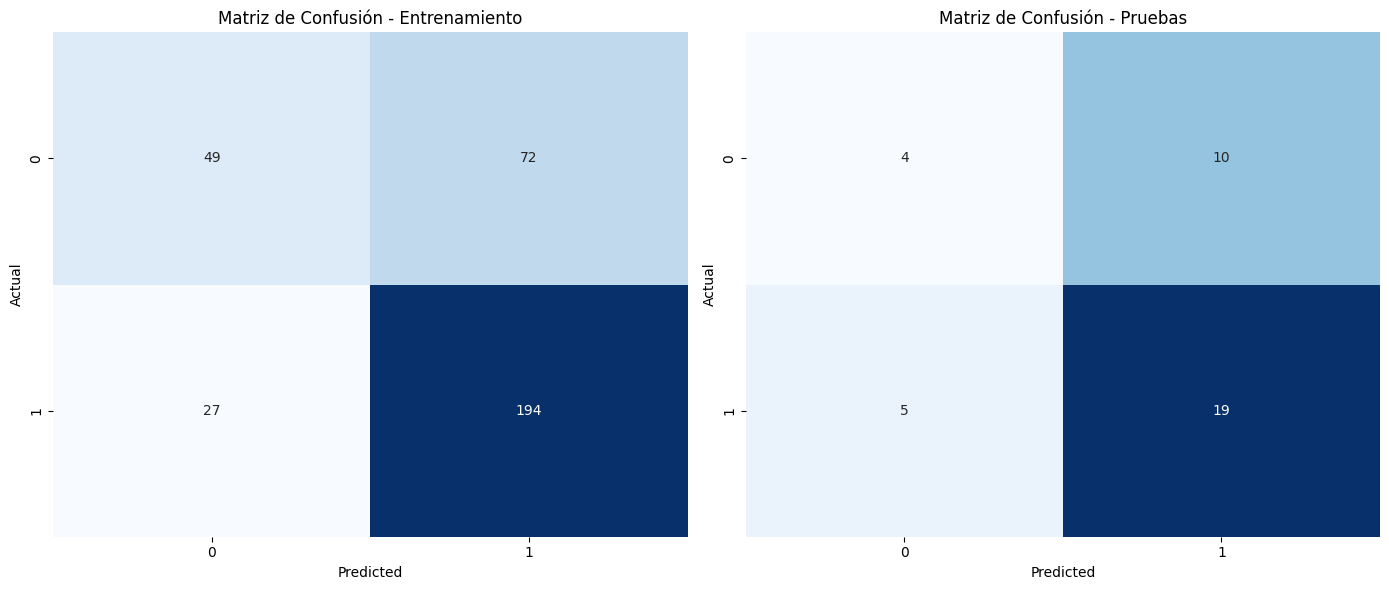

In [30]:
# Generamos las matrices de confusión
cm_tv = confusion_matrix(ytv1, ytv1_pred_ensamble1)
cm_test = confusion_matrix(ytest1, ytest1_pred_ensamble1)

# Creamos DataFrames de las matrices de confusión
cm_tv_df = pd.DataFrame(cm_tv, index=[0, 1], columns=[0, 1])
cm_test_df = pd.DataFrame(cm_test, index=[0, 1], columns=[0, 1])

# Creamos el heatmap usando seaborn
plt.figure(figsize=(14, 6))

# Heatmap de la matriz de confusión de entrenamiento
plt.subplot(1, 2, 1)
sns.heatmap(cm_tv_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Heatmap de la matriz de confusión de prueba
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión - Pruebas')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Finalmente mostramos las gráficas
plt.tight_layout()
plt.show()

## 3. Características relevantes

Ahora, para atender el objetivo principal del proyecto y encontrar las características que guarden una mayor relación con la ansiedad, primero observamos cuál de los dos modelos está aportando una mayor cantidad de información al ensamble.


In [31]:
# Obtenemos los coeficientes del modelo de ensamble (regresión logística)
coef_ensamble = ensamble1.coef_[0]

# Normalizamos los coeficientes para que sumen 1
importancia_modelos = np.abs(coef_ensamble) / np.sum(np.abs(coef_ensamble))

# Creamos un diccionario con la importancia de cada modelo
importancia_diccionario = {
    'Modelo': ['Regression Logística', 'SVM'],
    'Importancia': importancia_modelos
}

# Convertimos el diccionario en un DataFrame para facilitar la visualización
importancia_df = pd.DataFrame(importancia_diccionario)
importancia_df.set_index('Modelo', inplace=True)

print(importancia_df)

                      Importancia
Modelo                           
Regression Logística     0.853934
SVM                      0.146066


Observamos que la regresión logística es la que tiene una mayor relevancia dentro del ensamble, por lo que proponemos fijarnos ahora en los coeficientes obtenidos en dicha regresión, ya que, el signo y magnitud del coeficiente de una característica (y manteniendo fijas el resto de variables), indica el cambio en la sintomatología ansiosa con respecto al cambio en dicha característica. Ahora, recordando que al codificar la variable de síntomas ansiosos tenemos 0 y 1 para leve y moderado-grave respectivamente, podríamos interpretar que un coeficiente positivo y mayor de 0.5 indicaría que está ligado a una sintomatología ansiosa mayor. En cambio, un coeficiente negativo y menor a -0.5, indicaría que esa característica está ligada a una sintomatología ansiosa menor.

In [32]:
#ahora vamos a imprimir las 10 características ordenados por el valor de su coeficiente (en valor absoluto)
nombres = Xtv1.columns.tolist()

coeficientes_reg = reg.coef_[0]
coeficientes_caracteristicas_reg = dict(zip(nombres, coeficientes_reg))
importantes_reg = sorted(coeficientes_caracteristicas_reg.items(), key=lambda x: abs(x[1]), reverse=True)

print(f'Características más importantes de la regresión:\n')
for caracteristica, promedio in importantes_reg[:10]:
    print(f'{caracteristica}: {promedio}')

Características más importantes de la regresión:

OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.8870511555886651
OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana: 0.8215260311902899
OCUPACIoN_JEFE_FAMILIA_No determinado: 0.7453422349176607
RELIGION_Ateo: -0.6532604525212027
A3f_DIFICULTAD_CONCENTRACION: -0.5607270015261333
OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria: -0.5201028141983737
PROVEEDOR_FAMILIAR_Paciente: -0.5178782714670465
A3e_SINTO_INUTIL_CULPABLE: 0.49720046844495086
ESTADO_civil_Divorciado(a): 0.475007535448503
RELIGION_Ninguna: 0.4726924524748304


De las 10 características más relevantes para el modelo, observamos que solamente 7 son mayores a 0.5 en términos absolutos. Así, algunas conclusiones son:

* Observamos que cuando la ocupación del jefe de familia se refiere a puestos de menor jerarquía (empleado u operador de maquinaria), esto se traduce en una menor ansiedad para los pacientes. Esto podría estar asociado a que, en algunos casos, los trabajadores de bajo salario, al tener menos responsabilidades, pueden tener horarios más flexibles o menos demandantes, permitiéndoles tener más tiempo libre para pasar con la familia, además que, las personas en estratos económicos más bajos. con frecuencia forman parte de comunidades más estrechamente unidas, donde el apoyo social es fuerte, lo que proporciona una amplia red de apoyo emocional. En este contexto, y por el contrario, cuando la ocupación del jefe de familia sugiere mayores responsabilidades, esto impacta de manera negativa en el nivel de ansiedad de los pacientes. Finalmente, cuando la ocupación del jefe de familia fue reportada como "no determinada", y dado que el coeficiente es positivo y alto, podría deberse a que, en realidad, no hay un ingreso estable en la familia. La falta de recursos suficientes para cubrir necesidades básicas como vivienda, alimentación, salud y educación puede generar un alto nivel de estrés y ansiedad tanto en el jefe de familia como en sus familiares.

* Cuando el proveedor familiar es el propio paciente, esto parece tener un efecto positivo en los niveles de ansiedad. Esto podría deberse a que, al tener una rutina fija en el trabajo, el paciente cuenta con menos tiempo libre para invertir en pensamientos negativos que le generen ansiedad, además de que probablemente, tenga un mayor cansancio por el trabajo y traslados diarios que si no tuviera una actividad fija.

* En cuanto a la religión, si el paciente es ateo el coeficiente nos indica una mayor propensión a síntomas ansiosos más altos. Una posible causa puede radicar en el hecho que las personas religiosas pueden utilizar la oración como mecanismos de afrontamiento para cualquier causa que genere estrés y ansiedad. La falta de estas prácticas puede dejar a los ateos sin esta herramienta para encontrar fuerza y consuelo. Además, los ateos pueden enfrentar una mayor incertidumbre existencial ya que las creencias religiosas a menudo proporcionan respuestas a preguntas existenciales sobre el propósito de la vida.

* Finalmente, la dificultad de concentración parece tener un efecto positivo en los niveles de ansiedad. La dificultad para concentrarse puede ocasionar una desconexión de todos los factores externos, incluidos aquellos que generan estrés o ansiedad. Además, en algunos trastornos psiquiátricos, las dificultades de concentración pueden estar acompañadas de un estado en que las emociones, incluida la ansiedad, sean menos intensas